In [1]:
import collections
import gc
import itertools
import os
import sys
sys.path.append("/workspace/mta_vision_transformers/")
from collections import OrderedDict
from typing import Any, Callable, Dict, Iterable, List, Set, Tuple

import numpy as np
import einops
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils.data
from matplotlib import pyplot as plt
from tensordict import TensorDict
from torch.utils._pytree import tree_flatten

from core.monitor import Monitor
from infrastructure import utils
from infrastructure.settings import DEVICE, OUTPUT_DEVICE, DTYPE
from dataset.construct import ImageDataset
from dataset.library import DATASETS


dataset_name, n_classes = DATASETS["Common"][1]
OUTPUT_DIR = "experiments/plots"
EXPERIMENT_DIR = "figures"
if not os.path.exists(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}"):
    os.makedirs(f"{OUTPUT_DIR}/{EXPERIMENT_DIR}", exist_ok=True)
    
# Ocean: 901085904
# Rose: 100390212
torch.set_printoptions(linewidth=400, sci_mode=False)

/opt/conda/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Seed: 1149496617


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from modeling.openclip_vit import OpenCLIPViT

# SECTION: Set up dataset
torch.set_default_device(DEVICE)

batch_size = 50
dataset = ImageDataset(dataset_name, split="train", return_original_image=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(DEVICE))
original_images, images = next(iter(dataloader))

model = OpenCLIPViT()
monitor_config = {"model.visual.transformer.resblocks": "layer_output"}
monitor = Monitor(model, monitor_config, device=DEVICE)

log = monitor.reset()
with torch.no_grad():
    model.forward(images)

In [18]:
from cuml.manifold import TSNE
from torch_pca import PCA
from nystrom_ncut import NCut, SampleConfig, rgb_from_euclidean_tsne_3d

from visualize.base import get_rgb_colors


base_layer_idx = 8
# base_points = torch.tensor(TSNE(n_components=2).fit_transform(log["layer_output"][base_layer_idx][0].flatten(0, -2)))
base_points = PCA(n_components=2).fit_transform(log["layer_output"][base_layer_idx][0].flatten(0, -2))
# base_points = NCut(
#     n_components=2,
#     distance="rbf",
#     sample_config=SampleConfig(
#         method="random",
#         num_sample=20000,
#     ),
#     eig_solver="svd_lowrank"
# ).fit_transform(log["layer_output"][base_layer_idx][0].flatten(0, -2))

nc = NCut(
    n_components=100,
    distance="rbf",
    sample_config=SampleConfig(
        method="random",
        num_sample=20000,
    ),
    eig_solver="svd_lowrank"
).fit_transform(log["layer_output"][base_layer_idx][0].flatten(0, -2))
colors = rgb_from_euclidean_tsne_3d(nc)

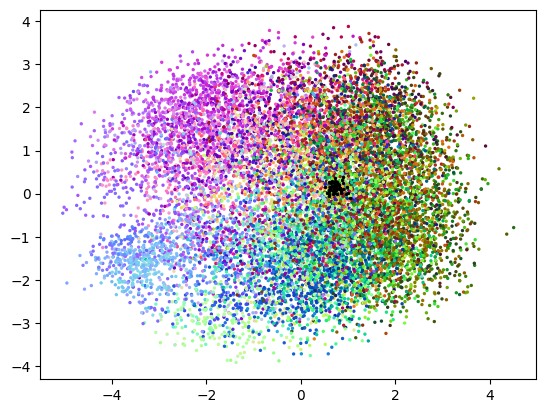

In [19]:
plt.scatter(*base_points.mT.numpy(force=True), color=colors.numpy(force=True), s=2)
plt.scatter(*base_points.view((batch_size, -1, 2))[:, 0].mT.numpy(force=True), s=2, color="black")
plt.show()

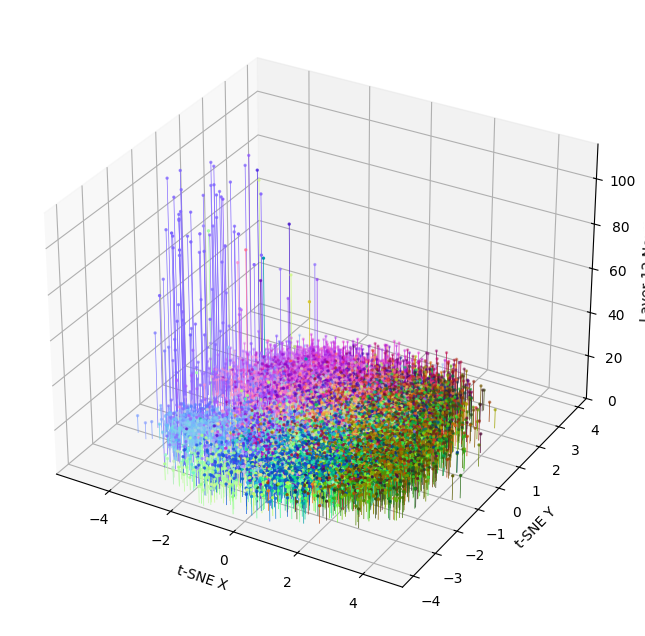

In [20]:
# Extract the layer 12 output norms
top_output = log["layer_output"][11][0].flatten(0, -2)
top_norms = torch.norm(top_output, dim=1)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot lines from the base (x, y, 0) to (x, y, z)
for i in range(len(base_points)):
    x, y = base_points[i].numpy(force=True)
    z = top_norms[i].numpy(force=True)
    ax.plot([x, x], [y, y], [0, z], color=colors[i].numpy(force=True), linewidth=0.5)

# # Scatter plot for the base points (optional, for better visualization)
# ax.scatter(
#     base_points[:, 0].numpy(force=True),
#     base_points[:, 1].numpy(force=True),
#     [0] * len(base_points),  # All points lie on the z=0 plane
#     c=colors.numpy(force=True),
#     s=2
# )

# Scatter plot for the top points (optional, for better visualization)
ax.scatter(
    base_points[:, 0].numpy(force=True),
    base_points[:, 1].numpy(force=True),
    top_norms.numpy(force=True),
    c=colors.numpy(force=True),
    s=2
)

# Set labels for the axes
ax.set_xlabel("t-SNE X")
ax.set_ylabel("t-SNE Y")
ax.set_zlabel("Layer 12 Norms")
ax.set_zlim(bottom=0)

# Show the plot
plt.show()